### Twitch Chat Analysis
#### Ethan Chang
#### ec778

# 1. Data Collection

Data was collected based on 3 criteria:
1. The weekly top 5 saved videos from the top 10 categories on https://www.twitch.tv/directory
2. Stream selected language must be English
3. Two-way interaction must be allowed between the streamer and audience

Due to these requirements video selction had to be manual, as there were several factors which may have thrown off the data:
1. Viewbotting: i.e. unusually high viewer count with little to no chat messages
2. Miscategorizing: i.e. selected Minecraft category when not a minute of Mincraft is in the stream, selecting English when the majority of the chat is in Russian
3. Interaction: No esports or competitive streams were analyzed, as streamers may not be allowed to interact with chat or may be too focused on competing to do so

## Vod Information

Infomation on each video was scraped using a list of manually collected URLs. Twitch has APIs but the documentation was subapar and scraping seemed more fun. Since webpages were dynamically generated using js, bs4 and requests could not get the info needed. Instead, the requests_html library was used which simulates a web browser visit and can render dynamic webpage HTML which was scraped using requests_html built in functions.

In [1]:
#!pip install requests-html

In [2]:
#!python scrapevodinfo.py

## Chatlogs
The chat data itself would have been difficut to scrape as only 10 minutes of chat are rendered at a time and the API does not support chat download. Credit goes to GitHub user freaktechnik who published code which simplified the download process: https://github.com/freaktechnik/twitch-chatlog

Downlaoding chat was handled by twitch-chatlog, I just scripted it to automatically download based on video info inputted and to output the results into .txt files

It was common for the download to fail (theorized to be server rate limits), so I outputted all the failed downloads to another .txt in case the user wanted to run it again without re-downloading the entire set.

In [3]:
#!pip install twitch-chatlog

In [4]:
#!python downloadchat.py

#you may have to run this multiple times on server denials
#change source code to read from 'vodinfos.csv' to 'downloaderrors.csv'
#after first attempt, command line arguments coming in next version

# 2. Data Format
## vodinfos.csv
This is a file which contains information about all videos to be downloaded. 

vodID: a unique identifier for the video

Streamer: who the content is produced by

Category: which category the streamer set the stream to premiere in

Views: 'Total Views' of the video

Length: HH:MM:SS string of how long the recording is

Views and Length are most important, becuase they can be used to create statistics which normalize chat frequency based on the number of viewers and how long the video is. (More viewers = more messages, longer video = more messages)

## {vodID}chatlog.txt
Individual chatlogs of each video, using their respective vodIDs as file identifers. The data is structured as:

\[Date, Time\] <Username\> Message

The message contais the most important data as that is what needs to be analyzed.

The date and time could prove to be useful for mapping message frequency to time of day

Usernames seems the least useful, but can be used to find repeat messages or the number of times they sent messages

# 3. Descriptive Statistics
First we need to read our initial data into dataframes

In [5]:
import pandas as pd

In [6]:
import os

In [7]:
import numpy as np

In [8]:
import seaborn as sns

In [9]:
vods = pd.read_csv('data/vodinfos.csv')

In [10]:
vods

,vodID,Streamer,Category,Views,Length
0,582450357,pokimane,VALORANT,48803,6:09:23
1,586414260,summit1g,VALORANT,33124,19:30:02
2,582316795,LIRIK,VALORANT,24846,8:18:07
3,585591205,DrDisrespect,VALORANT,17095,17:20:16
4,585505615,Tfue,VALORANT,16394,13:39:09
...,...,...,...,...,...
95,603513799,TSM_Bjergsen,League of Legends,20647,05:38:48
96,597627964,Destiny,League of Legends,9047,11:58:13
97,596920202,Nightblue3,League of Legends,8774,04:52:04
98,597525767,Yassuo,League of Legends,7045,10:15:21


Since the amount of viewers and the total time will influence th enumber of messages sent in a stream. Viewerhours (views * length) is a naive metric which can normalize it. Assuming that each viewer watched the entire duration of the stream, it can be used to find normalized rates so all streams can be comparable.

In [11]:
def get_hours(time_str):
    h, m, s = time_str.split(':')
    return float(h) + float(m)/60 + float(s)/3600

In [12]:
for index, row in vods.iterrows():
    numviewers = float(vods.at[index, 'Views'])
    numhours = get_hours(vods.at[index, 'Length'])
    vods.at[index, 'ViewerHours'] = round(numviewers * numhours, 3)

The block below appends the chat data and counts the number of messages

In [13]:
cwd = os.getcwd()
for index, row in vods.iterrows():
    vodid = row['vodID']
    file = os.path.join(cwd, f'data\{vodid}chatlog.txt')
    with open(file, 'r', encoding='utf-8') as f:
        vods.at[index, 'Chatlog'] = f.read()
        #print(f.read())

In [14]:
for index, row in vods.iterrows():
    vods.at[index, 'NumMessages'] = len(vods.at[index, 'Chatlog'].split('\n'))

One normalized metric we can use is Messages per ViewerHour. This measures the efficiency which a streamer can get an audience to interact using chat

In [15]:
vods['Mess/ViewHour'] = vods['NumMessages'] / vods['ViewerHours']

In [16]:
import matplotlib.pyplot as plt

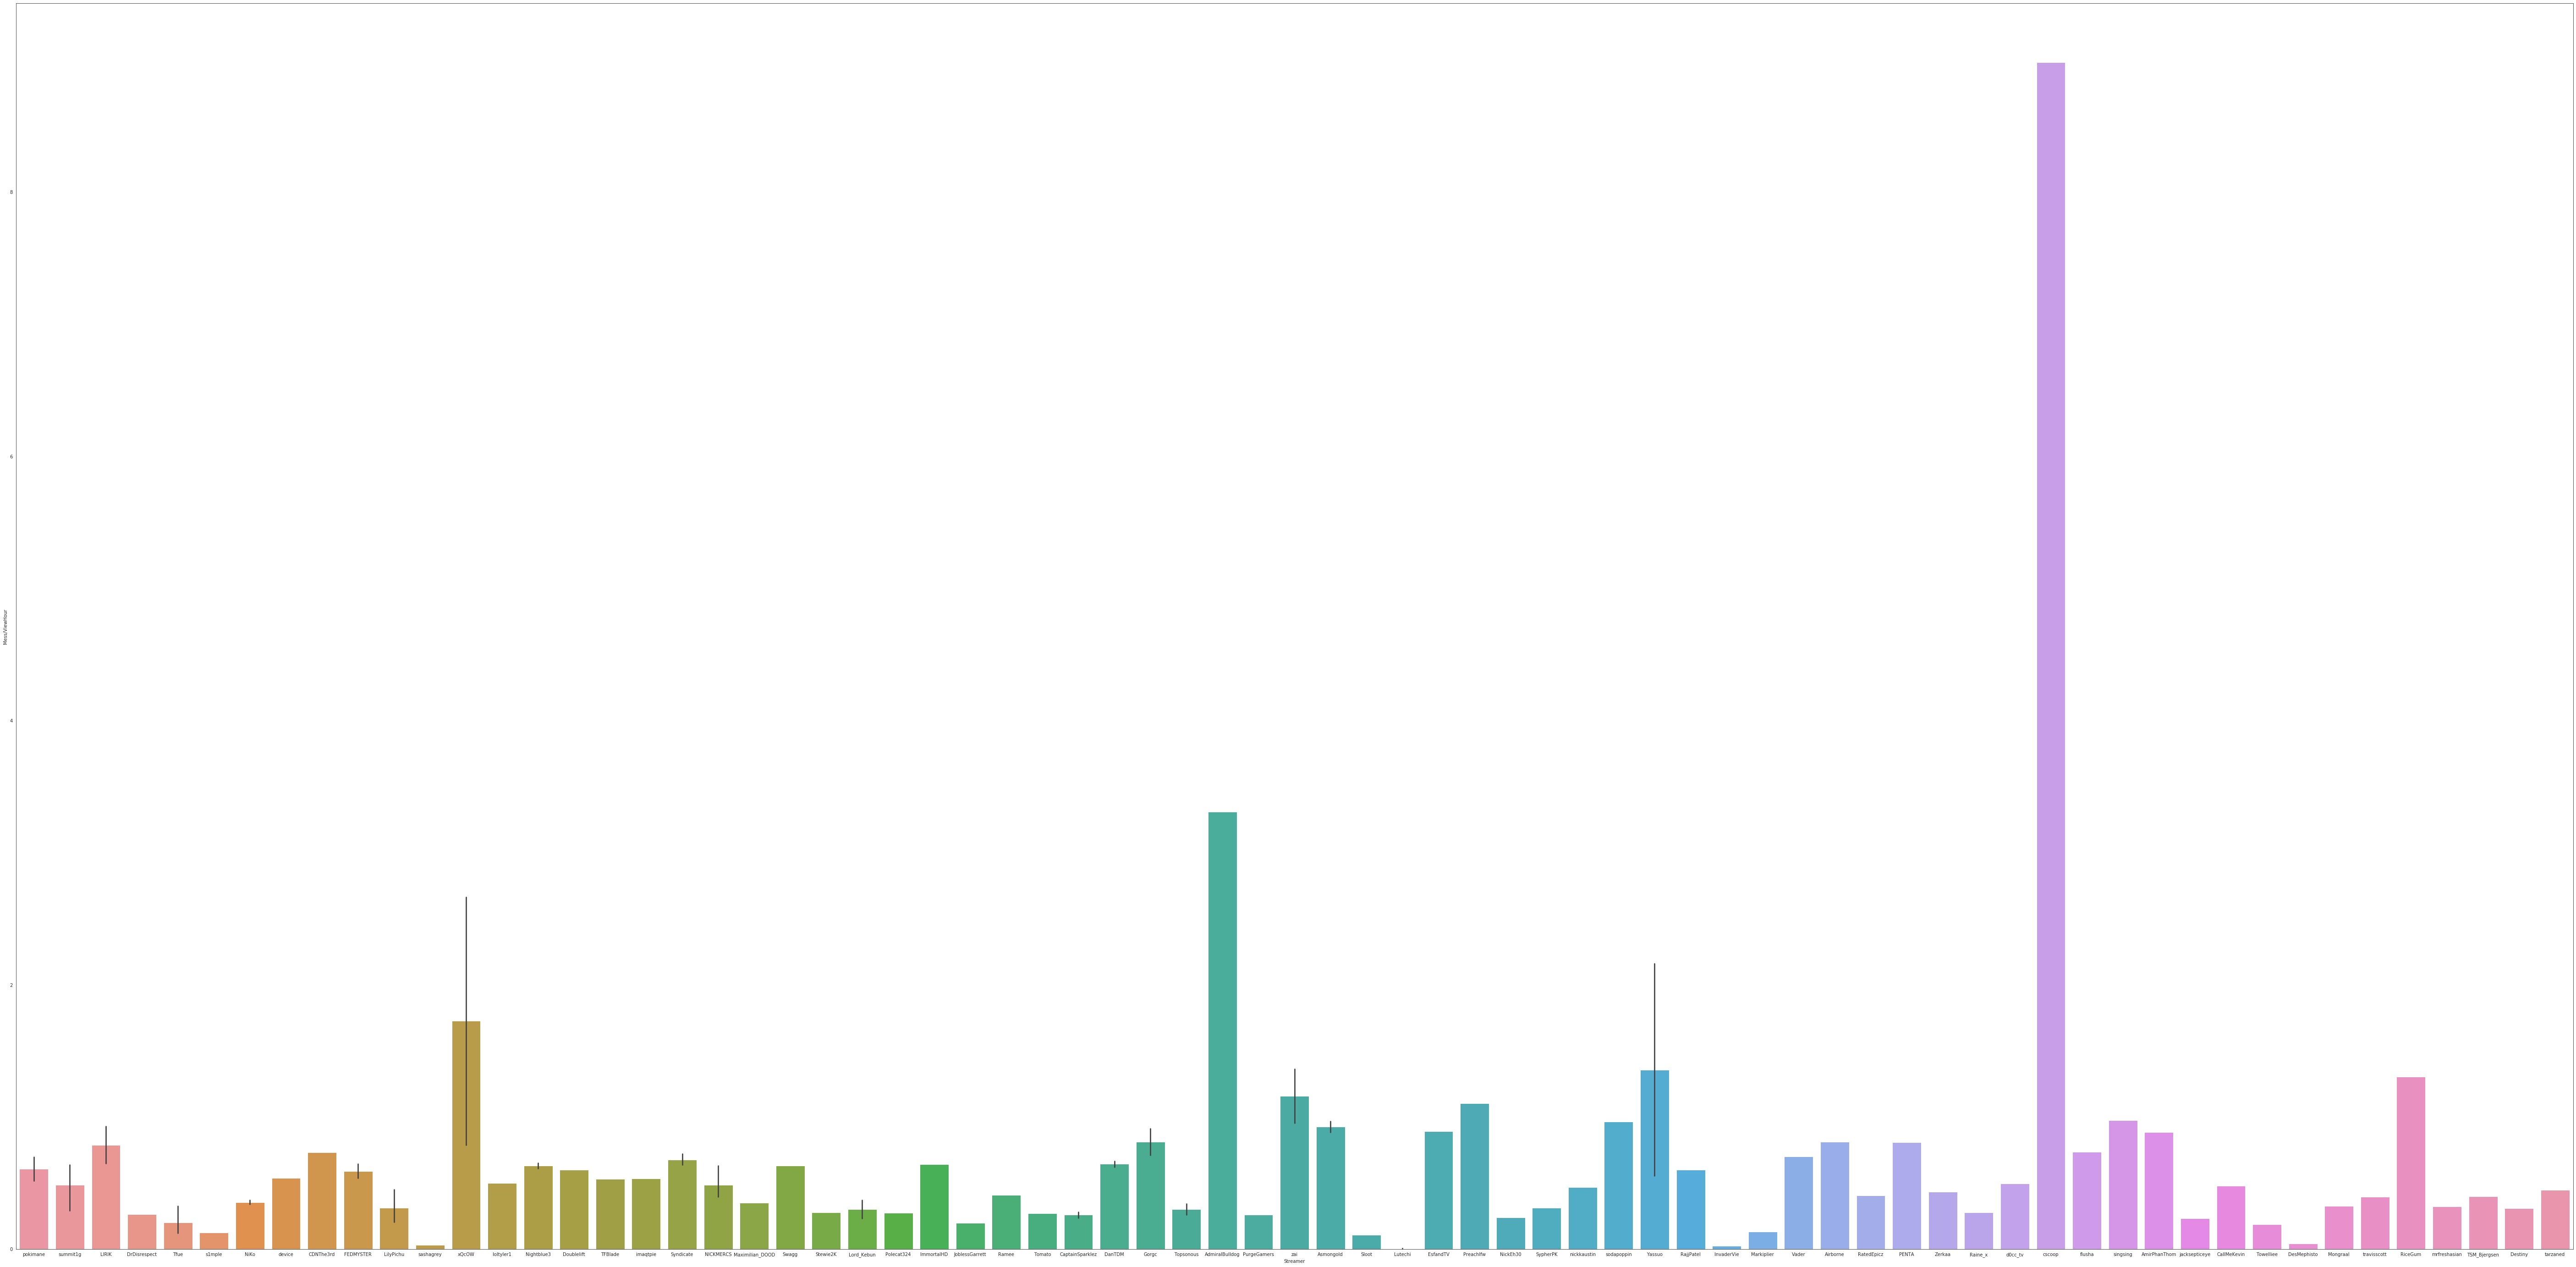

In [17]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(100, 50))
    sbp = sns.barplot(x ='Streamer', y ='Mess/ViewHour', data=vods)

This is apparantely the most engaging streamer in the dataset

In [18]:
vods.loc[vods['Mess/ViewHour'].idxmax(),]

vodID                                                    597898786
Streamer                                                    cscoop
Category                          Counter-Strike: Global Offensive
Views                                                         1539
Length                                                    01:06:44
ViewerHours                                                1711.71
Chatlog          [04/20/20, 07:09:54 PM] <voodoo694209> HEY COO...
NumMessages                                                  15371
Mess/ViewHour                                              8.97991
Name: 73, dtype: object

In [19]:
vods['Mess/ViewHour'].mean()

0.637884657162236

Now the text data needs to be modified by cutting out non-relevant data and gettting it into a standard format. The code uses regular expressions and sets everything to lower. Note that it purposely keeps symbols as they may be relevant: D:, </3, ( ͡° ͜ʖ ͡°)

In [20]:
import re

In [21]:
for index, row in vods.iterrows():
    messages = vods.at[index, 'Chatlog']
    messages = re.sub(r'\[.*\] <.*> ', '', messages)
    messages = re.sub(r'\w\. ', ' ', messages)
    messages = re.sub(r'\n', ' ', messages).lower()
    #messagelist = messages.split()
    
    vods.at[index, 'NormalizedChat'] = messages

Filtering out non-English words is tricky, as there are symbols which have relevant meaning and nondictionary slang. Just pray that the streamer put their stream into the right language category

In [22]:
#!pip install findspark

In [23]:
import findspark
findspark.init()

In [24]:
import pyspark #does not work in python 3.8

In [25]:
sc = pyspark.SparkContext('local', 'Chat Word Count')

In [26]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover()
stopwords = remover.getStopWords()
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [27]:
vods['WordCounts'] = np.nan
vods = vods.astype({'WordCounts': 'object'})

In [28]:
for index, row in vods.iterrows():
    print(index)
    tokens = vods.at[index, 'NormalizedChat'].split()
    counts = sc.parallelize(tokens)\
        .filter(lambda word: word not in stopwords)\
        .map(lambda word: (word, 1))\
        .reduceByKey(lambda a, b: a + b)
    vods.at[index, 'WordCounts'] = counts.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [29]:
def sort_tups(freqs):
    return(sorted(freqs, key = lambda x: float(x[1]), reverse = True))

In [30]:
for index, row in vods.iterrows():
    vods.at[index, 'WordCounts'] = sort_tups(vods.at[index, 'WordCounts'])

In [31]:
vods = vods.sort_values(by = ['Category', 'Streamer']).reset_index(drop=True)

In [32]:
vods

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts
0,586269537,Maximilian_DOOD,Call of Duty: Modern Warfare,8212,4:54:50,40352.856,"[04/8/20, 02:16:31 AM] <DirkFalcon> @Jae_Benny...",14099.0,0.349393,@jae_benny you should just hijack the stream h...,"[(doodshine, 4022), (doodscrub, 2618), (doodbr..."
1,582494540,NICKMERCS,Call of Duty: Modern Warfare,8002,11:33:06,92436.437,"[04/3/20, 03:41:31 PM] <Playmaker_Baker> nickm...",33238.0,0.359577,nickmercshypers nickmercshypers nickmercshyper...,"[(nickmercssub, 2372), (nickmercslove, 1967), ..."
2,599519474,NICKMERCS,Call of Duty: Modern Warfare,13438,04:08:26,55640.786,"[04/22/20, 02:41:59 PM] <Izabelle_Airen> nickm...",35017.0,0.629340,nickmercshypers nickmercshypers nickmercshyper...,"[(nickmercslg, 5398), (nickmercslove, 3422), (..."
3,594969677,NICKMERCS,Call of Duty: Modern Warfare,10905,11:21:09,123799.012,"[04/17/20, 05:32:01 PM] <Izabelle_Airen> Jebai...",58449.0,0.472128,jebaited jebaited nickmercsyurr kevinturtle tr...,"[(nickmercslove, 16374), (nickmercsfam, 6183),..."
4,583550926,Stewie2K,Call of Duty: Modern Warfare,6299,9:23:32,59161.608,"[04/4/20, 07:16:15 PM] <Steelnex> sumSmash OME...",16370.0,0.276700,sumsmash omegalul come to mibr stewie wassup s...,"[(@stewie2k, 720), (lul, 613), (1, 609), (!res..."
...,...,...,...,...,...,...,...,...,...,...,...
95,595201302,Lutechi,World of Warcraft,8655,05:33:20,48083.333,"[04/17/20, 10:02:24 PM] <BamesJond88> oh hey\n...",241.0,0.005012,oh hey @lutechi good evening lutechi is now li...,"[(stream, 15), (click, 13), (again., 13), (enj..."
96,595201302,Lutechi,World of Warcraft,8655,05:33:20,48083.333,"[04/17/20, 10:02:24 PM] <BamesJond88> oh hey\n...",241.0,0.005012,oh hey @lutechi good evening lutechi is now li...,"[(stream, 15), (click, 13), (again., 13), (enj..."
97,587528336,Preachlfw,World of Warcraft,4644,2:09:03,9988.470,"[04/9/20, 02:52:09 PM] <Preecherify> SPAM pgeC...",11021.0,1.103372,spam pgechub this pgechub chub pgechub to pgec...,"[(pgechub, 4141), (@preachlfw, 907), (pog, 598..."
98,587405000,Sloot,World of Warcraft,17200,16:52:15,290178.333,"[04/9/20, 12:30:23 PM] <dimmrill> HeyGUys\n[04...",30755.0,0.105987,heyguys good morning! slootcomfy slootcomfy he...,"[(@sloot, 2414), (pog, 1755), (pgechub, 1270),..."


# 4. Data Analysis, Visualization, and Insights

First, we'll get that altair requirement out of the way.

We'll do this by ploting the most common words for vod 582494139, which belongs to sashagrey.

In [33]:
vods.loc[vods['vodID'] == 582494139]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts
58,582494139,sashagrey,Just Chatting,44364,6:36:37,293258.363,"[04/3/20, 03:41:05 PM] <Sobryus> Hullo chat\n[...",9471.0,0.032296,hullo chat doors are open 1 hi chat and mods w...,"[(sasha, 367), (/, 303), (like, 300), (lol, 27..."


In [34]:
import altair as alt

In [35]:
from vega_datasets import data

In [36]:
counts = list(vods.loc[vods['vodID'] == 582494139, 'WordCounts'])[0]

In [37]:
# turn the list of tuples into a dataframe
grey = pd.DataFrame(counts[:100], columns = ['Word', 'Count'])

In [38]:
bars = alt.Chart(grey).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Word', sort='-x')
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='Word'
)

(bars + text).properties(height=1000, width=600)

alt.LayerChart(...)

The most used words were references to the streamers name, indicating that the chat was most interested in the streamer herself. Notice the '@sashagrey' frequency, which tags the streamer in chat and highlights the message, indicating that the chat was constantly trying to get her attention. This also indicates that the stream has a high level of interactivity with the chat.

Lower down on the list we encounter words like 'zombies', 'jill', 'evil' which all most likely came up when she changed the content of her stream from 'Just Chatting' to playing 'Resident Evil 3'

### Finding cosine similarities between all chatlogs

In [39]:
import math

Finding the magnitude (length) of each vector

In [40]:
def vectormag(vectortups):
    s = 0
    for (word, count) in vectortups:
        s += math.pow(int(count), 2)
    return math.sqrt(s)

In [41]:
for index, row in vods.iterrows():
    vods.at[index, 'VectorMag'] = vectormag((vods.at[index, 'WordCounts']))

Creating normalized vectors for each stream

In [42]:
vods['NormVect'] = np.nan
vods = vods.astype({'NormVect': 'object'})

In [43]:
for index, row in vods.iterrows():
    d = {}
    mag = float(vods.at[index, 'VectorMag'])
    for (word, count) in vods.at[index, 'WordCounts']:
        d[word] = float(count) / mag
    vods.at[index, 'NormVect'] = d

Getting dot product for each vector with every other vector

In [44]:
def dotprod(dic1, dic2):
    prod = 0
    for key, val in dic1.items():
        if key in dic2:
            prod += dic1[key] * dic2[key]
            #print(dic1[key])
    return prod

In [45]:
size = len(vods['vodID'])
cos = pd.DataFrame(index=vods['vodID'],columns=vods['vodID'])

In [46]:
for i in range(0, size):
    for j in range (i, size): #cols l to r
        d1 = vods.at[i, 'NormVect']
        d2 = vods.loc[j, 'NormVect']
        cos.iloc[j, i] = dotprod(d1, d2)

In [47]:
cos

vodID,586269537,582494540,599519474,594969677,583550926,586099353,583042155,597368829,595977551,596334556,...,582256476,596600109,596685265,587518680,583673637,595201302,595201302,587528336,587405000,594505723
vodID,,,,,,,,,,,,,,,,,,,,,
586269537,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582494540,0.150714,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
599519474,0.0745289,0.670506,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594969677,0.0657986,0.701177,0.615763,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583550926,0.157125,0.286344,0.149342,0.144216,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595201302,0.0795085,0.246336,0.113713,0.117575,0.232089,0.251618,0.0196579,0.0418938,0.0203784,0.0315726,...,0.0969275,0.0992664,0.399446,0.0356777,0.624828,1,NaN,NaN,NaN,NaN
595201302,0.0795085,0.246336,0.113713,0.117575,0.232089,0.251618,0.0196579,0.0418938,0.0203784,0.0315726,...,0.0969275,0.0992664,0.399446,0.0356777,0.624828,1,1,NaN,NaN,NaN
587528336,0.0454807,0.113906,0.0537344,0.0555911,0.118589,0.0874764,0.00840837,0.0167617,0.00751776,0.012658,...,0.0970601,0.0938057,0.164974,0.0237248,0.0772968,0.0992377,0.0992377,1,NaN,NaN


Now we can visualize the information in a heat map using seaborn. The v1 heatmap should be included image in ...\streamchat\indexcos.png for viewing convenience.

In [48]:
cos = cos.astype(float)

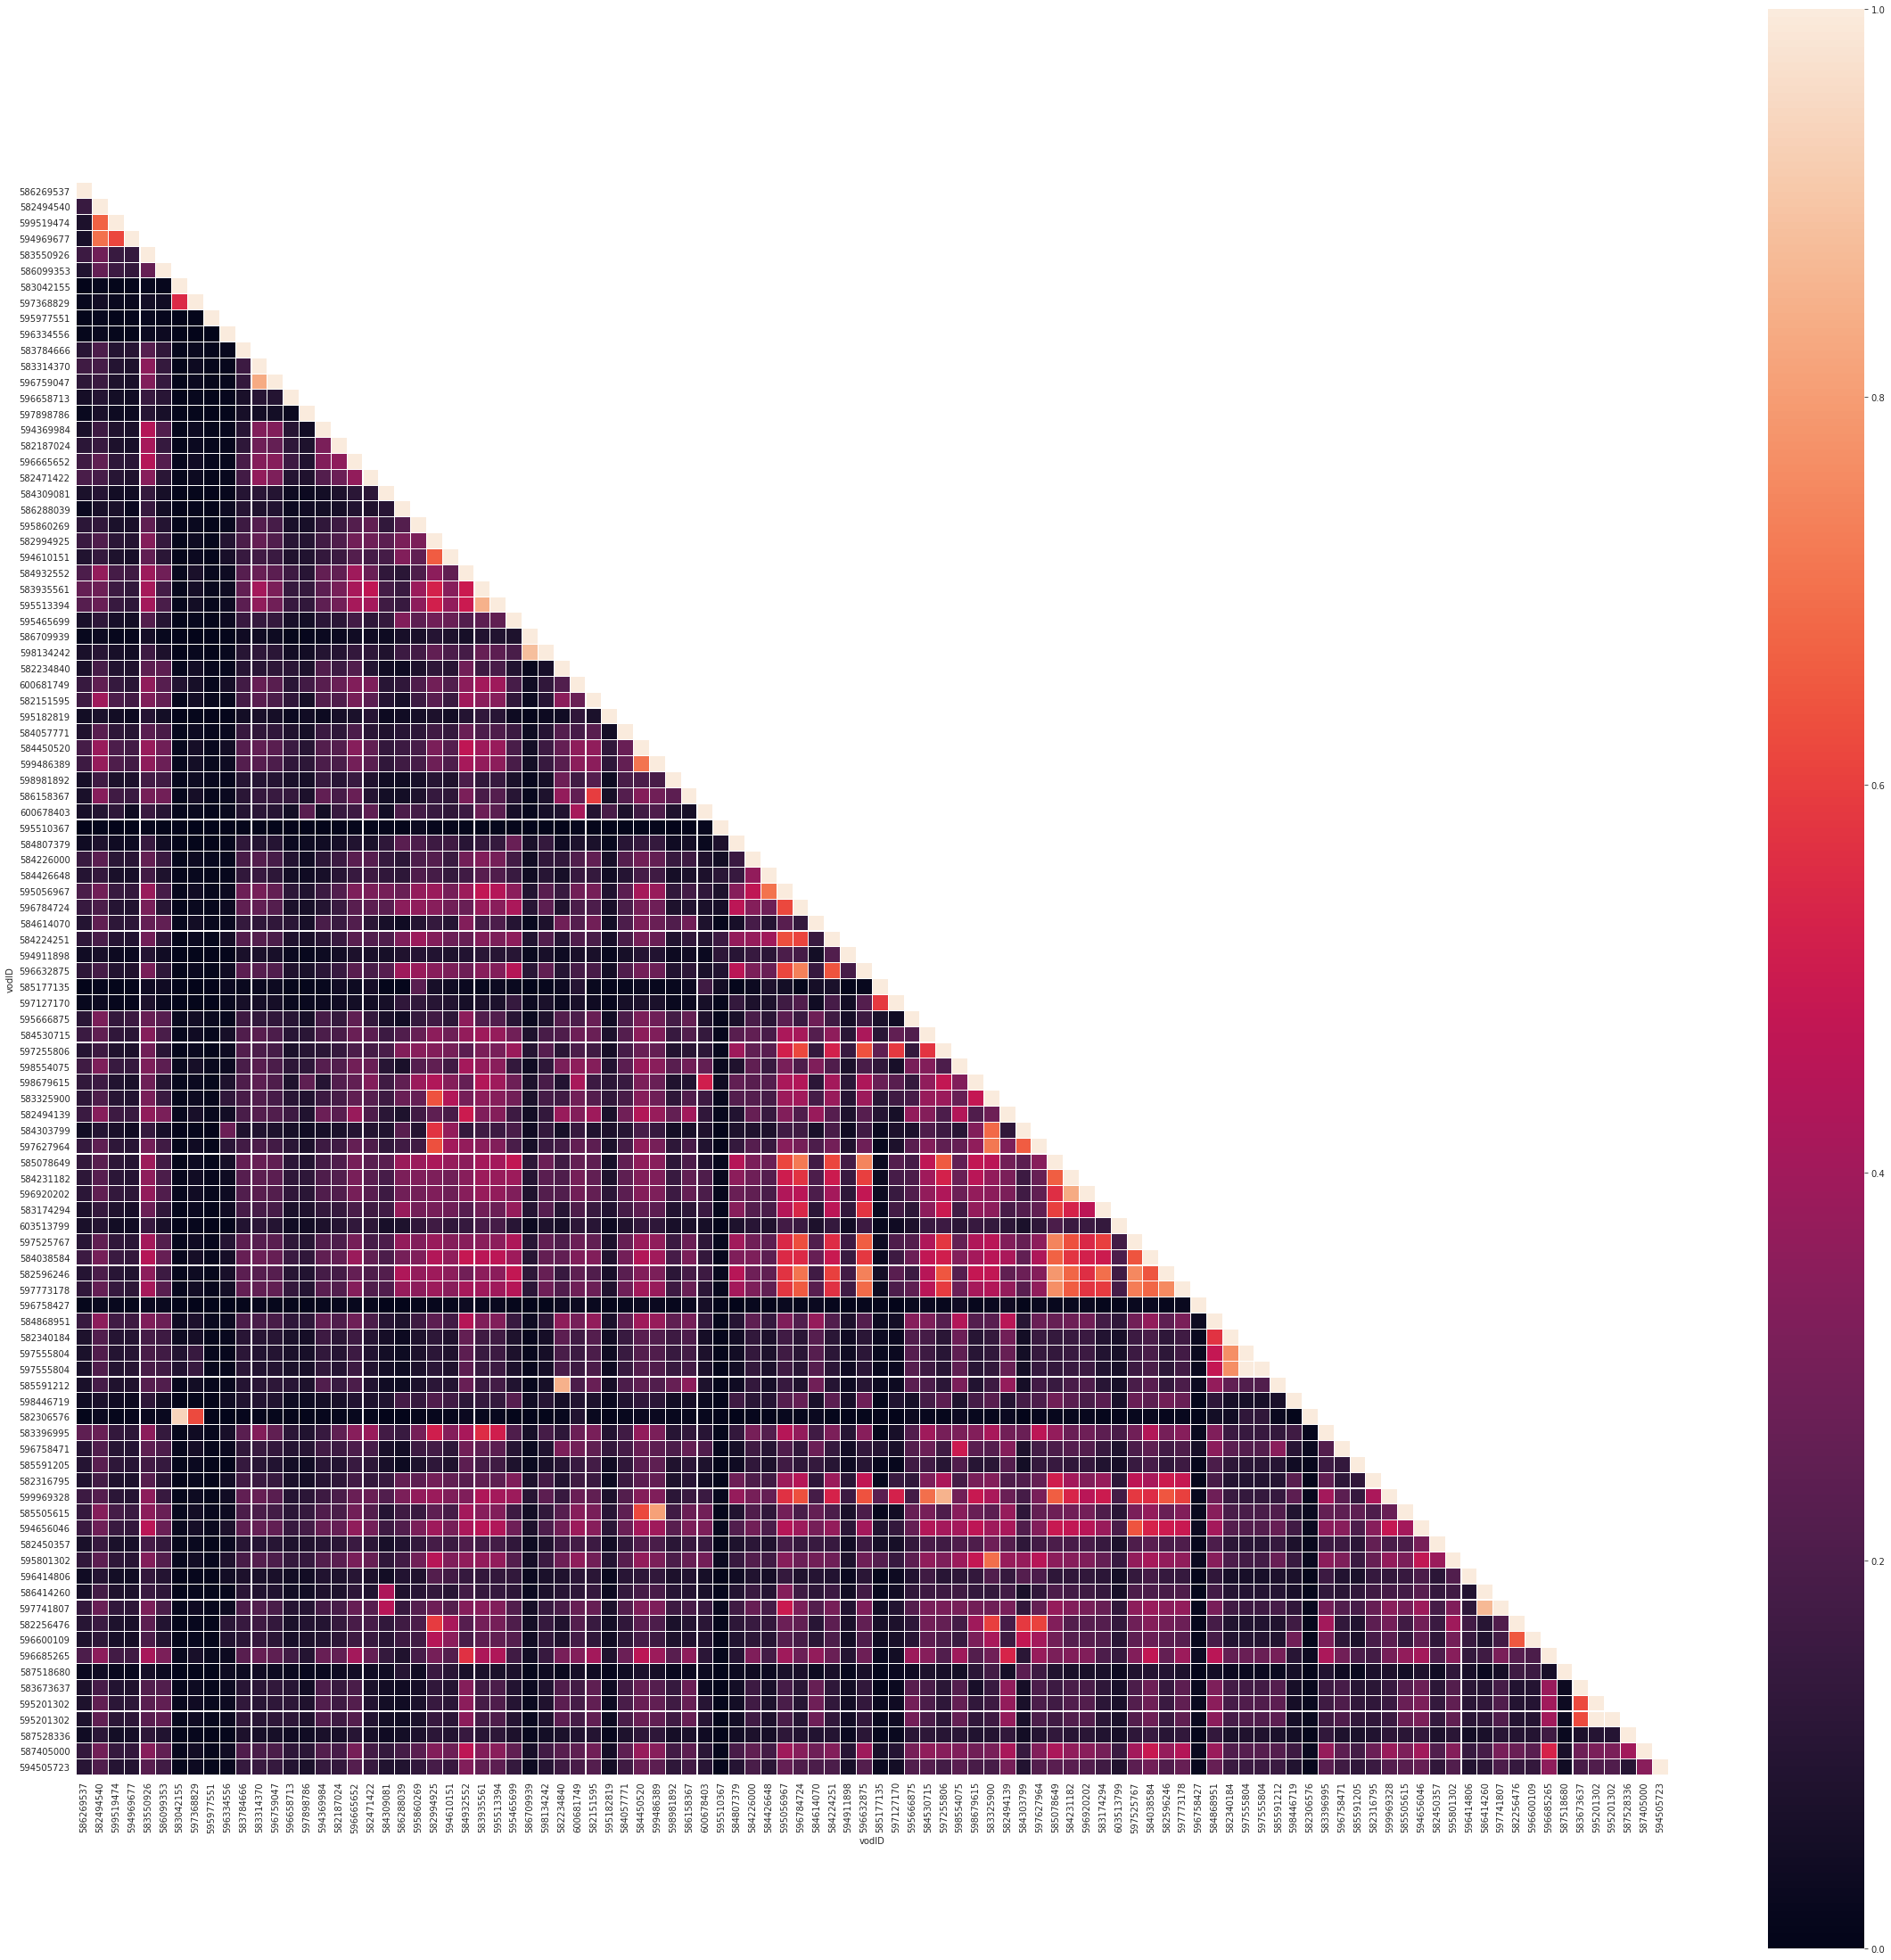

In [49]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(40, 40))
    ax = sns.heatmap(data=cos, vmin=0, vmax=1, linewidth=0.1, square=True)

# Visually Interesting Points:
   1. (582306576, 583042155): entirely black column and row except for itself and this point,
   2. (585177135, ): entirely black column except itself,
   3. (585591212, 582234840): very high similiarity,
   4. (, [584038584-584231182]): square cluster of hot spots near edge
   5. ([594303799, 583325900], 582994925): adjacent points which are bright, possibly suggesting 582994925's relationship to a category
   6. (584224251 , 585078649): Cherry picked warm spot which is far from diagnol, so it's not likely to be the same category

We can look at vodinfo for a naive explanation to these points.

### 1. The odd one out

In [50]:
vods.loc[(vods['vodID'] == 582306576) | (vods['vodID'] == 583042155)]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts,VectorMag,NormVect
6,583042155,Syndicate,Call of Duty: Modern Warfare,11345,8:02:57,91317.796,"[04/4/20, 07:48:43 AM] <deathridah> Tea\n[04/4...",58304.0,0.638474,tea yo# yes!! yoooo toooooooooooooooom hello e...,"[(syndigg, 30964), (syndi115, 29984), (syndipo...",58874.553620,"{'syndigg': 0.5259318006833609, 'syndi115': 0...."
77,582306576,Syndicate,Minecraft,10999,3:35:26,39492.521,"[04/3/20, 11:47:34 AM] <archiebxld> Live he is...",28465.0,0.720769,live he is live tom there we go why can’t i se...,"[(syndigg, 13897), (syndipog, 11119), (syndiye...",24884.152145,"{'syndigg': 0.5584678922853117, 'syndipog': 0...."


In [51]:
cos[583042155][582306576]

0.9408021149679923

Possible Expanaition: Both videos are by the same streamer, so the content and viewerbase should be similar. Also, the private emotes will be the same, causing high similiarity values. Note the complete disimilarity between his streams and all the other streams from other streamers, suggesting that Syndicate may have one of the most unique chats on twitch

### 2. The black column

In [52]:
vods.loc[vods['vodID'] == 585177135]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts,VectorMag,NormVect
50,585177135,FEDMYSTER,Just Chatting,55503,0:26:28,24482.99,"[04/6/20, 07:00:43 PM] <Nyfe> fed7\n[04/6/20, ...",15805.0,0.64555,fed7 : 🥕 hypers i got spam in the chat so my c...,"[(<3, 30291), (fedl, 26750), (fed7, 21586), (b...",46389.899051,"{'<3': 0.6529654217706127, 'fedl': 0.576634149..."


Explanation: This video is very short compared to other streams which run for hours. During this video, there may not have been sufficient time for chat messages, causing this vector to be somewhat unique

### 3. The bright spot

In [53]:
vods.loc[(vods['vodID'] == 585591212) | (vods['vodID'] == 582234840)]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts,VectorMag,NormVect
30,582234840,DanTDM,Fortnite,10333,1:52:50,19431.781,"[04/3/20, 09:50:51 AM] <smileyisland> yyayayya...",12085.0,0.621919,yyayayyayayayaya yeah i completed all of them ...,"[(dan, 1308), (hi, 951), (deadpool, 490), (u, ...",2240.886878,"{'dan': 0.5836974694440754, 'hi': 0.4243855454..."
75,585591212,DanTDM,Minecraft,13072,2:36:25,34077.978,"[04/7/20, 09:35:08 AM] <xxlycon> ok ok but sti...",22687.0,0.665738,ok ok but still yeyyeye yaaaaaaaaaaaaaaaaaaaaa...,"[(dan, 2257), (hi, 1661), (@dantdm, 776), (u, ...",3980.359280,"{'dan': 0.5670342401475742, 'hi': 0.4172990132..."


In [54]:
cos[582234840][585591212]

0.8493274706777362

Again, this is the same streamer for both streams, however his streams tend to be more similar to other streamers than the other case

### 4. The hot clique
Cluster of high value tiles near diaganol

In [55]:
 vods.loc[(vods['vodID'] == 584231182) | (vods['vodID'] == 585078649) | (vods['vodID'] == 583174294) | (vods['vodID'] == 584038584)]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts,VectorMag,NormVect
61,585078649,Doublelift,League of Legends,7361,4:40:34,34420.854,"[04/6/20, 04:41:10 PM] <aramintha_> fuck it im...",20609.0,0.598736,fuck it im watching dl stream today daddys her...,"[(kekw, 2527), (@doublelift, 1209), (pog, 1002...",3637.999863,"{'kekw': 0.6946124506504271, '@doublelift': 0...."
62,584231182,Nightblue3,League of Legends,9297,8:45:02,81353.915,"[04/5/20, 03:24:22 PM] <condemedbanana> AYYYYY...",49753.0,0.611562,ayyyyyyyyyy pog check out the yt nb3sip https:...,"[(kekw, 4739), (nb3int, 2011), (@nightblue3, 1...",8399.543083,"{'kekw': 0.5641973561273739, 'nb3int': 0.23941..."
64,583174294,TFBlade,League of Legends,4943,4:49:06,23817.022,"[04/4/20, 11:35:32 AM] <skydazex> where is he ...",12658.0,0.531469,where is he guys yep cock yes baxk yep cock he...,"[(kekw, 1323), (lp, 644), (tridance, 565), (5h...",2383.767606,"{'kekw': 0.5550037665592369, 'lp': 0.270160563..."
67,584038584,imaqtpie,League of Legends,4525,8:04:48,36562.000,"[04/5/20, 11:15:17 AM] <Vendeur> no\n[04/5/20,...",19563.0,0.535064,no we survived yet another waiting time qt coo...,"[(kekw, 1132), (qt, 1068), (@imaqtpie, 869), (...",2769.955956,"{'kekw': 0.4086707578919107, 'qt': 0.385565697..."


All these are videos of the game, League of Legends it makes sense the content is similar. This may suggest that all league streams are of the same flavor.

### 5. An unusual set
A pair of relatively warm tiles

In [56]:
vods.loc[vods['vodID'] == 582994925]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts,VectorMag,NormVect
22,582994925,Gorgc,Dota 2,5845,7:07:50,41678.097,"[04/4/20, 05:43:42 AM] <Nienlol> LIVE!? POGGIE...",38007.0,0.911918,live!? poggies zed poggies z vislaud pogu earl...,"[(lulw, 2971), (lul, 2544), (pog, 2173), (omeg...",7301.240443,"{'lulw': 0.406917156526398, 'lul': 0.348433943..."


In [57]:
cos[582994925][584303799] #with xqc

0.5732332960969759

In [58]:
cos[582994925][583325900] #with pokimane

0.6390244225846029

That video is somewhat similar to these two and visually identifiable to be similar on the map:

In [59]:
vods.loc[(vods['vodID'] == 584303799) | (vods['vodID'] == 583325900)]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts,VectorMag,NormVect
57,583325900,pokimane,Just Chatting,33507,3:16:22,109660.965,"[04/4/20, 02:44:20 PM] <Raphael2885> LULW\n[04...",76543.0,0.697997,lulw f f rage quit stream pepelaugh f noooo f ...,"[(lulw, 5204), (omegalul, 2901), (pepelaugh, 2...",10579.977552,"{'lulw': 0.4918724992034985, 'omegalul': 0.274..."
59,584303799,xQcOW,Just Chatting,42120,10:05:45,425236.500,"[04/5/20, 04:54:34 PM] <wherearethejuices> Pog...",335303.0,0.788509,pogu pogu pogu pogu pogu pogu pogu pogu pagcho...,"[(lulw, 45381), (pogu, 32377), (pepelaugh, 270...",93804.794174,"{'lulw': 0.48378124380178705, 'pogu': 0.345152..."


In [60]:
cos[583325900][584303799] #pokimane and xqc

0.6837174960624276

But these two streams are actually more similar to each other than the first one, but likely didn't draw my attention on the map because the set wasn't as large. Let's see what the chats for these 3 streams look like.

In [61]:
def printList(list, lim):
    i = 0
    for item in list:
        print(item[:lim])

In [62]:
printList(vods.loc[vods['vodID'] == 582994925, 'WordCounts'], 50) #Gorgc

[('lulw', 2971), ('lul', 2544), ('pog', 2173), ('omegalul', 1922), ('peepoleave', 1512), ('@gorgc', 1499), ('pepelaugh', 1371), ('gorp', 1095), ('weirdchamp', 1071), ('sadge', 936), ('sumsmash', 916), ('jebaited', 820), ('winning', 801), ('bruh', 783), ('pogu', 761), ('aghs', 703), ('peepoarrive', 664), ('alienrave', 660), ('feelsrainman', 638), ('chat', 634), ('yep', 597), ('og', 584), ('!np', 558), ('losing', 556), ('?', 554), ('kekw', 553), ('<3', 540), (':)', 529), ('wtff', 523), ('clap', 517), ('pick', 501), ('game', 500), ('u', 493), ('krappa', 473), ('1', 465), ('5', 460), ('carried', 452), ('kappa', 447), ('pogchamp', 444), ('teatime', 435), ('nigma', 428), ('!score', 422), ('topson', 386), ('get', 374), ('stream', 369), ('go', 366), ('pepehands', 366), ('peepochat', 363), ('monkaw', 352), ('gorgc', 351)]


In [63]:
printList(vods.loc[vods['vodID'] == 584303799, 'WordCounts'], 50) #xqc

[('lulw', 45381), ('pogu', 32377), ('pepelaugh', 27089), ('omegalul', 25534), ('clap', 20253), ('weirdchamp', 17932), ('xqcl', 17719), ('⠀', 15930), ('pepega', 15378), ('yep', 15126), ('kreygasm', 13467), ('monkaw', 13018), ('gachihyper', 12796), ('@xqcow', 9068), ('5head', 9009), ('forsenpls', 8805), ('xqck', 8648), ('chat', 8536), ('zulul', 7777), ('stay', 7714), ('cmonbruh', 7705), ('enjoyed', 7587), ('lul', 7450), ('pepejam', 7387), ('peped', 7119), ('ayaya', 6899), ('d:', 6408), ('cock', 6275), ('pepehands', 6016), ('3head', 5756), ('waytoodank', 5750), ('kkool', 5532), ('ez', 5218), ('dansgame', 5179), ('\U000e0000', 5157), ('true', 5010), ('vr', 4934), ('pog', 4911), ('guitartime', 4779), ('forsencd', 4744), ('widepeepohappy', 4558), ('wtf', 4307), ('trihard', 4294), ('ppoverheat', 4079), ('moxy', 4054), ('go', 4044), ('left', 3920), ('😂', 3754), ('hypers', 3489), ('teatime', 3475)]


In [64]:
printList(vods.loc[vods['vodID'] == 583325900, 'WordCounts'], 50) #pokimane

[('lulw', 5204), ('omegalul', 2901), ('pepelaugh', 2760), ('lul', 2464), ('kekw', 2151), ('@pokimane', 1872), ('pokilove', 1666), ('pokilol', 1495), ('pokiheart', 1461), ('clap', 1403), ('<3', 1314), ('pog', 1247), ('pogu', 1206), ('uno', 1155), ('poki', 1108), ('cmonbruh', 1087), ('xqcstare', 1076), ('u', 1043), ('\U000e0000', 990), ('good', 978), ('weirdchamp', 959), ('yes', 936), ('pepega', 919), ('stream', 879), ('monkaw', 869), ('f', 863), ('kreygasm', 840), ('lol', 834), ('d:', 795), ('busta', 754), ('play', 729), ('teatime', 724), ('bottom', 712), ('widepeepohappy', 698), ('waiting', 691), ('left', 682), ('pvc', 678), ('xqc', 673), ('tridance', 670), ('ez', 665), ('late', 664), ('yikesjam', 656), ('w', 652), ('pepepains', 646), ('new', 631), ('wtf', 626), ('like', 598), ('true', 598), ('say', 565), ('pepejam', 564)]


All 3 have a 'lulw' as their most common word as well as the standard emotes 'pepelaugh', 'omegalul', and 'kekw', indicating that the streams may have been humorful. Interesting, xqcOW's custom emotes can be seen in the top words of pokimane's chat, suggesting that there is an overlap between the two audiences.

### 6. Cherry picking
Hot tile

In [65]:
vods.loc[(vods['vodID'] == 585078649) | (vods['vodID'] == 584224251)]

,vodID,Streamer,Category,Views,Length,ViewerHours,Chatlog,NumMessages,Mess/ViewHour,NormalizedChat,WordCounts,VectorMag,NormVect
47,584224251,Ramee,Grand Theft Auto V,5888,11:30:19,67743.076,"[04/5/20, 03:16:29 PM] <CamPepper> Pog\n[04/5/...",27750.0,0.409636,pog pogu sadkek hey ramee sadkek @ramee weirdc...,"[(kekw, 3443), (rameelove, 3355), (lul, 1594),...",6085.659373,"{'kekw': 0.5657562786819528, 'rameelove': 0.55..."
61,585078649,Doublelift,League of Legends,7361,4:40:34,34420.854,"[04/6/20, 04:41:10 PM] <aramintha_> fuck it im...",20609.0,0.598736,fuck it im watching dl stream today daddys her...,"[(kekw, 2527), (@doublelift, 1209), (pog, 1002...",3637.999863,"{'kekw': 0.6946124506504271, '@doublelift': 0...."


In [66]:
cos[585078649][584224251]

nan

From the information at hand, I have no idea why these are so similar. Printing word counts

In [67]:
printList(vods.loc[vods['vodID'] == 585078649, 'WordCounts'], 50) #Doublelift

[('kekw', 2527), ('@doublelift', 1209), ('pog', 1002), ('lul', 894), ('play', 503), ('lol', 427), ('u', 393), ('yep', 376), ('game', 337), ('lulw', 335), ('league', 288), ('pogu', 276), ('kappa', 259), ('subscribed', 257), ('cock', 252), ('lsxyzokay', 237), ('leena', 231), ('f', 218), ('doublelift', 213), ('watch', 206), ('tyler', 201), ('good', 198), ('d:', 198), ('greek', 192), ('?', 188), ('vs', 188), ('t1', 187), ('get', 182), ('stream', 180), ('go', 180), ('lmao', 179), ('pepehands', 175), ('kreygasm', 170), ('back', 162), ('twitch', 161), ('think', 160), ('chat', 158), ('omegalul', 156), ('one', 155), ('like', 153), ('playing', 150), ('csgo', 150), ('dl', 148), ('1', 144), ('tl', 143), (':)', 134), ('na', 132), ('tsm', 130), ('monkas', 130), ('adc', 129)]


In [68]:
printList(vods.loc[vods['vodID'] == 584224251, 'WordCounts'], 50) #Doublelift

[('kekw', 3443), ('rameelove', 3355), ('lul', 1594), ('sadkek', 1334), ('widepeepohappy', 1105), ('pog', 919), ('@ramee', 713), ('lol', 684), ('<3', 593), ('kebuncg', 573), ('ramee', 550), ('kappa', 545), ('pogu', 422), ('lmao', 410), ('cg', 401), ('pepelaugh', 371), ('like', 370), ('get', 366), ('1', 344), ('toxic', 343), ('chang', 332), ('rameechanggang', 323), ('lulw', 318), ('omegalul', 316), ('uchi', 314), ('shotzcg', 312), ('rameekek', 302), ('kebunluv', 286), ('big', 283), ('go', 262), ('shotzl', 259), ('tier', 252), ('pogo', 249), ('bro', 240), ('u', 239), ('chat', 233), ('pepepls', 221), ('car', 220), ('monkaw', 216), ('ratedelove', 210), ('shit', 209), ('sub', 207), ('gifted', 202), ('d', 199), ('rameelaugh', 199), ('need', 196), ('got', 193), (':)', 192), ('nice', 191), ('going', 190)]


Both sets contain similar words at large quantities, such as 'kekw', 'lul', 'pog', etc. This may suggest that the viewerbase uses similar vocabulary or that the content of the streams influences viewers to type certain messages

## Conclusions
1. Content by streamers is most similar to other content by that streamer
2. Categories are a good way of grouping similar streams together, especially League of Legends
3. Some streamers may have unique content or styles which cause their chat to be unique
4. Some surprising correlations can be found based on emote use, especially emotes denoting humor, suggesting that Twitch chatters respond well to humor and that it can be used to attract audiences from other streamers

## Thank You
Part of the process of writing this code was streamed on my Twitch.
You can follow my work at:
https://www.twitch.tv/artilleryparty

https://www.youtube.com/channel/UC1ayU7fxpIrtXAH8fRUBZyA

https://github.com/e10-atp/

https://www.linkedin.com/in/ethanchang98/
